In [1]:
import VariationalBayes.Parameters as par
from VariationalBayes.MultinomialParams import SimplexParam

import math

from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import copy
import scipy
from scipy import optimize
from scipy import stats

In [2]:
# Number of data points:
n_num = 1000

# Dimension of observations:
d_num = 2

# Number of clusters:
k_num = 5

true_pi = np.linspace(0.2, 0.8, k_num)
true_pi = true_pi / np.sum(true_pi)

true_z = np.random.multinomial(1, true_pi, n_num)
true_z_ind = np.full(n_num, -1)
for row in np.argwhere(true_z):
    true_z_ind[row[0]] = row[1]

mu_prior_mean = np.full(d_num, 0.)
mu_prior_cov = np.diag(np.full(d_num, 3 ** 2))
true_mu = np.random.multivariate_normal(mu_prior_mean, mu_prior_cov, k_num)

true_sigma = np.array([ np.diag(np.full(d_num, 2 ** 2)) + np.full((d_num, d_num), 0.1) \
                        for k in range(k_num) ])

x = np.array([ np.random.multivariate_normal(true_mu[true_z_ind[n]], true_sigma[true_z_ind[n]]) \
               for n in range(n_num) ])


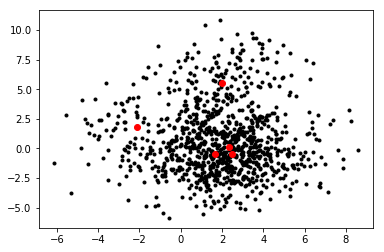

In [3]:
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

In [13]:
# Build an object to contain a variational approximation to a K-dimensional multivariate normal.
params = par.ModelParamsDict()

params.push_param(par.PosDefMatrixParamVector(name='sigma', length=k_num, matrix_size=d_num, val=true_sigma))
params.push_param(par.ArrayParam(name='mu', shape=(k_num, d_num), val=true_mu))
params.push_param(SimplexParam(name='z', shape=(n_num, k_num)))
params.push_param(par.VectorParam(name='pi', size=k_num, lb=0.0, val=true_pi))